In [1]:
# Importación de librerías necesarias
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
from gtda.graphs import GraphGeodesicDistance
from gtda.homology import VietorisRipsPersistence, SparseRipsPersistence, FlagserPersistence
from igraph import Graph
from IPython.display import SVG, display
import plotly.graph_objects as go
import networkx as nx
from itertools import combinations
import argparse
import numpy as np
import gudhi
import matplotlib.pyplot as plot
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
def count_strains(labels):
    strain_counts = {}
    strain_colors = {
        'H9N2': 'blue',
        'H7N9': 'orange',
        'H7N3': 'green'
    }
    for label in labels:
        strain = label.split('(')[1].split(')')[0]  # Extrae la cepa entre paréntesis
        strain_counts[strain] = strain_counts.get(strain, 0) + 1
    print("Número de secuencias para la prueba:")
    for strain, count in strain_counts.items():
        color = strain_colors.get(strain, 'gray')
        print(f"{strain} = {count} ({color})")
    return strain_colors

In [3]:
def visualize_simplicial_complex(simplex_tree, filtration_value, vertex_names=None, save_filename=None, plot_size=1000):
    G = nx.Graph()
    triangles = []
    tetrahedra = []
    edges = []
    hole_2d_simplices = []

    # Encontrar el agujero 2D
    persistence_2 = simplex_tree.persistence_intervals_in_dimension(2)
    if len(persistence_2) > 0:
        hole_birth = persistence_2[0][0]  # Asumiendo que solo hay un agujero 2D

    # Procesar cada simplex en el árbol de simplex
    for simplex, filt in simplex_tree.get_filtration():
        if filt <= filtration_value:
            if len(simplex) == 2:
                G.add_edge(simplex[0], simplex[1])
                edges.append(simplex)
            elif len(simplex) == 1:
                G.add_node(simplex[0])
            elif len(simplex) == 3:
                triangles.append(simplex)
                if filt == hole_birth:
                    hole_2d_simplices.append(simplex)
            elif len(simplex) == 4:
                tetrahedra.append(simplex)

    # Crear layout del grafo
    pos = nx.spring_layout(G, dim=3)

    # Obtener los colores de las cepas
    strain_colors = count_strains(vertex_names)

    # Crear trazas para nodos
    node_x, node_y, node_z = zip(*[pos[node] for node in G.nodes()])
    node_labels = [vertex_names[node] if vertex_names else str(node) for node in G.nodes()]
    node_colors = [strain_colors.get(label.split('(')[1].split(')')[0], 'gray') for label in node_labels]
    node_trace = go.Scatter3d(x=node_x, y=node_y, z=node_z, mode='markers+text', 
                              marker=dict(size=5, color=node_colors),
                              text=node_labels, textposition="top center", 
                              hoverinfo='text')

    # Crear trazas para aristas
    edge_x, edge_y, edge_z = [], [], []
    edge_colors = []
    for edge in G.edges():
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])
        # Comprobar si esta arista es parte del agujero 2D
        is_hole_edge = any(set(edge).issubset(triangle) for triangle in hole_2d_simplices)
        edge_colors.extend(['yellow' if is_hole_edge else 'black'] * 3)
    edge_trace = go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', 
                              line=dict(width=2, color=edge_colors), hoverinfo='none')

    # Crear trazas para triángulos
    triangle_traces = []
    for triangle in triangles:
        x = [pos[v][0] for v in triangle]
        y = [pos[v][1] for v in triangle]
        z = [pos[v][2] for v in triangle]
        color = 'yellow' if triangle in hole_2d_simplices else 'red'
        opacity = 0.7 if triangle in hole_2d_simplices else 0.3
        triangle_trace = go.Mesh3d(x=x, y=y, z=z, opacity=opacity, color=color)
        triangle_traces.append(triangle_trace)

    # Crear trazas para tetraedros
    tetrahedra_traces = []
    for tetrahedron in tetrahedra:
        x = [pos[v][0] for v in tetrahedron]
        y = [pos[v][1] for v in tetrahedron]
        z = [pos[v][2] for v in tetrahedron]
        tetrahedron_trace = go.Mesh3d(x=x, y=y, z=z, opacity=0.1, color='green')
        tetrahedra_traces.append(tetrahedron_trace)

    # Configurar el layout
    layout = go.Layout(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        ),
        margin=dict(r=0, l=0, b=0, t=0),
        showlegend=False
    )

    # Crear la figura y añadir las trazas
    fig = go.Figure(data=[node_trace, edge_trace] + triangle_traces + tetrahedra_traces, layout=layout)

    fig.update_layout(width=plot_size, height=plot_size)

    if save_filename:
        fig.write_image(save_filename, width=plot_size, height=plot_size, scale=1)

    fig.show()

    return G

In [4]:
# Leer la matriz desde el archivo
sG3 = np.loadtxt('matriz_resultante(control_negativo_infA-B).txt')

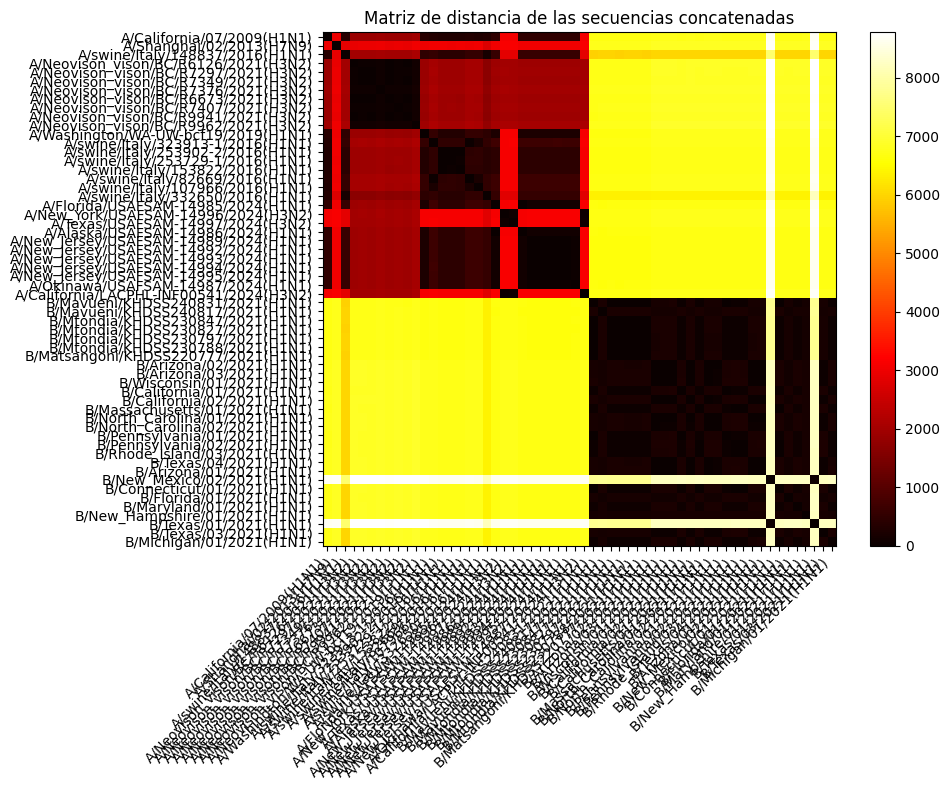

In [5]:
# Definir las etiquetas para las columnas y filas
labels = [
   'A/California/07/2009(H1N1)',
   'A/Shanghai/02/2013(H7N9)',
   'A/swine/Italy/148837/2016(H1N1)',
   'A/Neovison_vison/BC/R6126/2021(H3N2)',
   'A/Neovison_vison/BC/R7297/2021(H3N2)',
   'A/Neovison_vison/BC/R7349/2021(H3N2)',
   'A/Neovison_vison/BC/R7376/2021(H3N2)',
   'A/Neovison_vison/BC/R6673/2021(H3N2)',
   'A/Neovison_vison/BC/R7407/2021(H3N2)',
   'A/Neovison_vison/BC/R9941/2021(H3N2)',
   'A/Neovison_vison/BC/R9962/2021(H3N2)',
   'A/Washington/WA-UW-bcf19/2019(H1N1)',
   'A/swine/Italy/323913-1/2016(H1N1)',
   'A/swine/Italy/253902-2/2016(H1N1)',
   'A/swine/Italy/253729-1/2016(H1N1)',
   'A/swine/Italy/153822/2016(H1N1)',
   'A/swine/Italy/82669/2016(H1N1)',
   'A/swine/Italy/107966/2016(H1N1)',
   'A/swine/Italy/332650/2016(H1N1)',
   'A/Florida/USAFSAM-14985/2024(H1N1)',
   'A/New_York/USAFSAM-14996/2024(H3N2)',
   'A/Texas/USAFSAM-14997/2024(H3N2)',
   'A/Alaska/USAFSAM-14986/2024(H1N1)',
   'A/New_Jersey/USAFSAM-14989/2024(H1N1)',
   'A/New_Jersey/USAFSAM-14992/2024(H1N1)',
   'A/New_Jersey/USAFSAM-14993/2024(H1N1)',
   'A/New_Jersey/USAFSAM-14994/2024(H1N1)',
   'A/New_Jersey/USAFSAM-14995/2024(H1N1)',
   'A/Okinawa/USAFSAM-14987/2024(H1N1)',
   'A/California/LACPHL-INF00541/2024(H3N2)',
   'B/Mavueni/KHDSS240831/2021(H1N1)',
   'B/Mavueni/KHDSS240817/2021(H1N1)',
   'B/Mtondia/KHDSS230847/2021(H1N1)',
   'B/Mtondia/KHDSS230827/2021(H1N1)',
   'B/Mtondia/KHDSS230797/2021(H1N1)',
   'B/Mtondia/KHDSS230788/2021(H1N1)',
   'B/Matsangoni/KHDSS220777/2021(H1N1)',
   'B/Arizona/02/2021(H1N1)',
   'B/Arizona/03/2021(H1N1)',
   'B/Wisconsin/01/2021(H1N1)',
   'B/California/01/2021(H1N1)',
   'B/California/02/2021(H1N1)',
   'B/Massachusetts/01/2021(H1N1)',
   'B/North_Carolina/01/2021(H1N1)',
   'B/North_Carolina/02/2021(H1N1)',
   'B/Pennsylvania/01/2021(H1N1)',
   'B/Pennsylvania/02/2021(H1N1)',
   'B/Rhode_Island/03/2021(H1N1)',
   'B/Texas/04/2021(H1N1)',
   'B/Arizona/01/2021(H1N1)',
   'B/New_Mexico/02/2021(H1N1)',
   'B/Connecticut/01/2021(H1N1)',
   'B/Florida/01/2021(H1N1)',
   'B/Maryland/01/2021(H1N1)',
   'B/New_Hampshire/01/2021(H1N1)',
   'B/Texas/01/2021(H1N1)',
   'B/Texas/03/2021(H1N1)',
   'B/Michigan/01/2021(H1N1)'
]
# Crea una figura con 1 fila y 1 columna
fig, ax = plot.subplots(1, 1, figsize=(10, 8))

# Grafica la matriz sG3 como una gráfica de calor
im = ax.imshow(sG3, cmap='hot')

# Personaliza el subplot
ax.set_title('Matriz de distancia de las secuencias concatenadas')

# Establece las posiciones y etiquetas para las columnas y filas
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)

# Agrega una barra de colores
cbar = fig.colorbar(im, ax=ax)

# Muestra la figura
plot.tight_layout()
plot.show()

In [6]:
# Configurar parámetros para el complejo de Rips
max_edge_length = 2300
max_dimension = 5
band = 0.0

print("#####################################################################")
print("RipsComplex creation from defined distance matrix G3")


# Crear el complejo de Rips
rips_complex = gudhi.RipsComplex(
   distance_matrix=sG3, max_edge_length=max_edge_length  
)

#####################################################################
RipsComplex creation from defined distance matrix G3


In [7]:
# Crear el árbol de simplex
simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)
   
message = "Number of simplices=" + repr(simplex_tree.num_simplices()) 
print(message)

# Calcular la persistencia
diag = simplex_tree.persistence()

print("betti_numbers()=")
print(simplex_tree.betti_numbers())

Number of simplices=629065
betti_numbers()=
[4, 0, 0, 0, 0]


usetex mode requires dvipng.


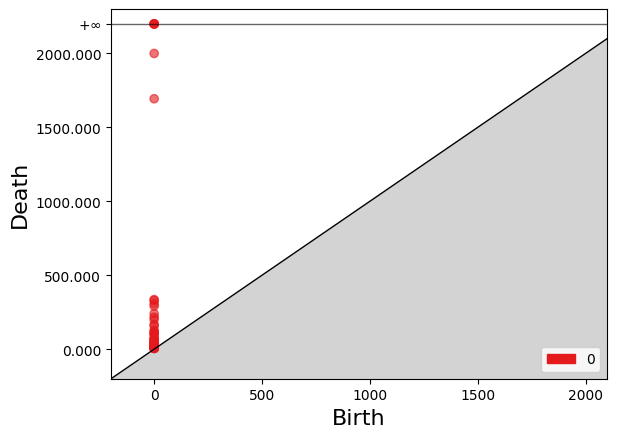

In [8]:
# Mostrar el diagrama de persistencia
gudhi.plot_persistence_diagram(diag, band=band)
plot.title("")
plot.show()

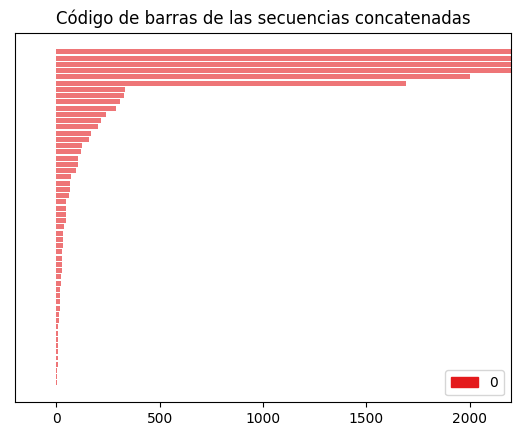

In [9]:
# Mostrar el código de barras
gudhi.plot_persistence_barcode(diag)
plot.title("Código de barras de las secuencias concatenadas")
plot.show()

In [59]:
simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)
   
message = "Number of simplices=" + repr(simplex_tree.num_simplices()) 
print(message)
  
diag = simplex_tree.persistence()

print("betti_numbers()=")
print(simplex_tree.betti_numbers())

# Add this new code to print birth and death times for 1D and 2D holes
print("\nPersistence intervals for 1-dimensional holes:")
for interval in simplex_tree.persistence_intervals_in_dimension(1):
    print(f"Birth: {interval[0]}, Death: {interval[1]}")

print("\nPersistence intervals for 2-dimensional holes:")
for interval in simplex_tree.persistence_intervals_in_dimension(2):
    print(f"Birth: {interval[0]}, Death: {interval[1]}")

Number of simplices=629065
betti_numbers()=
[4, 0, 0, 0, 0]

Persistence intervals for 1-dimensional holes:

Persistence intervals for 2-dimensional holes:


In [60]:
print("Visualizing 3D simplicial complex at filtration time 2025")
visualize_simplicial_complex(simplex_tree, 2025, vertex_names=labels)

Visualizing 3D simplicial complex at filtration time 2025


UnboundLocalError: local variable 'hole_birth' referenced before assignment